# 在卷积神经网络中使用更多的图片(图片扩增)
主要参考于[DeepLearning.ai课程](https://github.com/lmoroney/dlaicourse)

接下来我们构建一个更高效的学习模型去识别猫和狗。

它与您使用的先前模型相似，但是更新了图层定义。 请注意，现在有4个卷积层，分别具有32、64、128和128个卷积。

同时，这将训练100个epoch，因为想绘制损失和准确性的曲线图。

In [6]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 获取数据的路径
local_zip = 'tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('tmp')
zip_ref.close()

base_dir = 'tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')
validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')

# 构建模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

# 编译模型
model.compile(loss='binary_crossentropy',
             optimizer = RMSprop(lr=1e-4),
             metrics=['accuracy'])

# 预处理数据,并且创建图片生成器
train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (150,150),
        batch_size = 20,
        class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (150,150),
        batch_size = 20,
        class_mode = 'binary'
)

# 训练模型
history = model.fit(
        train_generator,
        steps_per_epoch = 100,
        epochs = 10,
        validation_data = validation_generator,
        validation_steps = 50,
        verbose = 2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 - 96s - loss: 0.6875 - accuracy: 0.5440 - val_loss: 0.6628 - val_accuracy: 0.6240
Epoch 2/10
100/100 - 87s - loss: 0.6555 - accuracy: 0.6010 - val_loss: 0.6328 - val_accuracy: 0.6700
Epoch 3/10
100/100 - 88s - loss: 0.6121 - accuracy: 0.6710 - val_loss: 0.5951 - val_accuracy: 0.6930
Epoch 4/10
100/100 - 93s - loss: 0.5703 - accuracy: 0.6950 - val_loss: 0.5859 - val_accuracy: 0.6840
Epoch 5/10
100/100 - 91s - loss: 0.5408 - accuracy: 0.7250 - val_loss: 0.5868 - val_accuracy: 0.7030
Epoch 6/10
100/100 - 89s - loss: 0.5193 - accuracy: 0.7430 - val_loss: 0.5682 - val_accuracy: 0.7010
Epoch 7/10
100/100 - 93s - loss: 0.4954 - accuracy: 0.7540 - val_loss: 0.6233 - val_accuracy: 0.6830
Epoch 8/10
100/100 - 100s - loss: 0.4743 - accuracy: 0.7670 - val_loss: 0.5731 - val_accuracy: 0.7010
Epoch 9/10
100

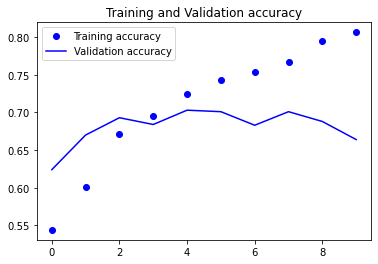

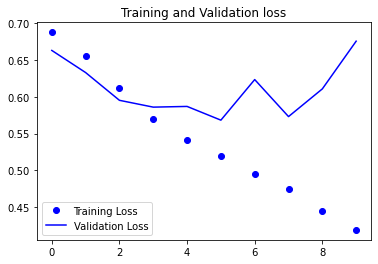

In [7]:
# 绘制对应的损失和精确度
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'bo',label='Training accuracy')
plt.plot(epochs,val_acc,'b',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training Loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title("Training and Validation loss")

plt.legend()
plt.show()

训练准确度接近100％，验证准确度在70％-80％范围内。 这是过度拟合的一个很好的例子-简而言之，这意味着它可以很好地处理以前看到的图像，但不能很好地处理过以前没有看到的图像。 让我们看看是否可以做得更好，**避免过度拟合:**一种简单的方法是稍微扩大图像。 如果您考虑一下，大多数猫的照片都非常相似-耳朵在顶部，然后是眼睛，然后是嘴等。诸如眼睛和耳朵之间的距离之类的东西也总是非常相似。

**Question：**如果我们对图像进行调整以稍微改变它，该怎么办？

**Answer：**旋转图像，挤压图像等。这就是图像扩增的全部内容。 可以使用一个容易的API实现。

现在看一下ImageGenerator。它上面有一些属性，你可以用它们来增强图像：


**代码讲解：**这些只是可用的选项中的一部分(更多信息，请参阅Keras文档)。让我们快速回顾一下刚刚写的内容

* rotation_range：一个以角度(0 180)为单位的值，在这个范围内可以随机旋转图片。
* width_shift and height_shift：作为总宽度或高度的一部分，在其中可以随机地垂直或水平地转换图片。
* shear_range：用于随机应用剪切变换。
* zoom_range：用于图片内部随机缩放。
* horizontal_flip：用于随机水平翻转一半的图像。
* fill_mode：于填充新创建的像素的策略，该像素可以在旋转或宽度/高度偏移后出现。

下面是我们添加图像增强的一些代码。运行它看看影响

In [10]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 获取数据的路径
local_zip = 'tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('tmp')
zip_ref.close()

base_dir = 'tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')
validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')

# 构建模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

# 编译模型
model.compile(loss='binary_crossentropy',
             optimizer = RMSprop(lr=1e-4),
             metrics=['accuracy'])

# 预处理数据,并且创建图片生成器，实现#图像扩增
train_datagen = ImageDataGenerator(
                            rescale = 1./255.,
                            rotation_range = 40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            fill_mode='nearest'
                            )

# 验证集数据不使用图像扩增
test_datagen = ImageDataGenerator(
                            rescale = 1./255.)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (150,150),
        batch_size = 20,
        class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (150,150),
        batch_size = 20,
        class_mode = 'binary'
)

# 训练模型
history = model.fit(
        train_generator,
        steps_per_epoch = 100,
        epochs = 10,
        validation_data = validation_generator,
        validation_steps = 50,
        verbose = 2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 - 96s - loss: 0.6946 - accuracy: 0.5140 - val_loss: 0.6888 - val_accuracy: 0.5000
Epoch 2/10
100/100 - 95s - loss: 0.6883 - accuracy: 0.5555 - val_loss: 0.6646 - val_accuracy: 0.6190
Epoch 3/10
100/100 - 95s - loss: 0.6763 - accuracy: 0.5895 - val_loss: 0.7035 - val_accuracy: 0.5080
Epoch 4/10
100/100 - 94s - loss: 0.6669 - accuracy: 0.5905 - val_loss: 0.6593 - val_accuracy: 0.5910
Epoch 5/10
100/100 - 94s - loss: 0.6526 - accuracy: 0.6155 - val_loss: 0.6218 - val_accuracy: 0.6450
Epoch 6/10
100/100 - 96s - loss: 0.6399 - accuracy: 0.6360 - val_loss: 0.5988 - val_accuracy: 0.6820
Epoch 7/10
100/100 - 121s - loss: 0.6231 - accuracy: 0.6535 - val_loss: 0.6116 - val_accuracy: 0.6370
Epoch 8/10
100/100 - 153s - loss: 0.6164 - accuracy: 0.6605 - val_loss: 0.5575 - val_accuracy: 0.7110
Epoch 9/10
10

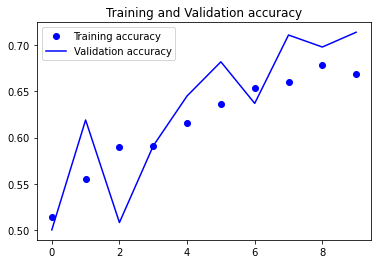

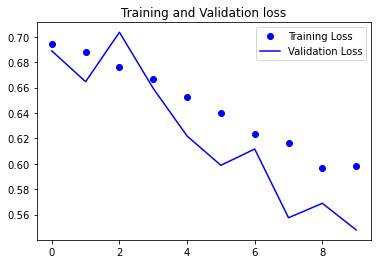

In [12]:
# 绘制对应的损失和精确度
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'bo',label='Training accuracy')
plt.plot(epochs,val_acc,'b',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training Loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title("Training and Validation loss")

plt.legend()
plt.show()